In [3]:
import requests

import altair as alt
import pandas as pd

alt.renderers.enable('svg')

RendererRegistry.enable('svg')

Download treatment duration data
Sample data is in `behandelduur-distribution-20200425.json



In [4]:
treatment_duration = requests.get("https://www.stichting-nice.nl/covid-19/public/behandelduur-distribution/").json()

In [5]:
# treatment_duration:
#
# [0]: levend_nog_opgenomen_ziekenhuis
# [1]: nog_opgenomen_ic
# [2]: levend_ziekenhuis_verlaten
# [3]: overleden
levend_nog_opgenomen_ziekenhuis = treatment_duration[0]
nog_opgenomen_ic = treatment_duration[1]
levend_ziekenhuis_verlaten = treatment_duration[2]
overleden = treatment_duration[3]

def parse_tuples(tpls, name: str) -> pd.DataFrame:
    # Push [0,0] to front of data so it starts at 0
    tpls[-1] = ((0,0))
    return pd.DataFrame(tpls, columns=['days', name]).set_index('days')

treatment_duration_df = parse_tuples(levend_nog_opgenomen_ziekenhuis, 'levend_nog_opgenomen_ziekenhuis')\
    .join(parse_tuples(nog_opgenomen_ic, 'nog_opgenomen_ic'), how='outer')\
    .join(parse_tuples(levend_ziekenhuis_verlaten, 'levend_ziekenhuis_verlaten'), how='outer')\
    .join(parse_tuples(overleden, 'overleden'), how='outer')\
    .fillna(0)
    # Fill all the 0's after joining because it may lengthen the data


In [6]:
# Cumulative sum by column
treatment_duration_df.cumsum().head()

,levend_nog_opgenomen_ziekenhuis,nog_opgenomen_ic,levend_ziekenhuis_verlaten,overleden
days,,,,
0,0,0,0.0,0.0
1,18,4,3.0,25.0
2,36,15,6.0,56.0
3,55,29,20.0,82.0
4,69,36,32.0,118.0


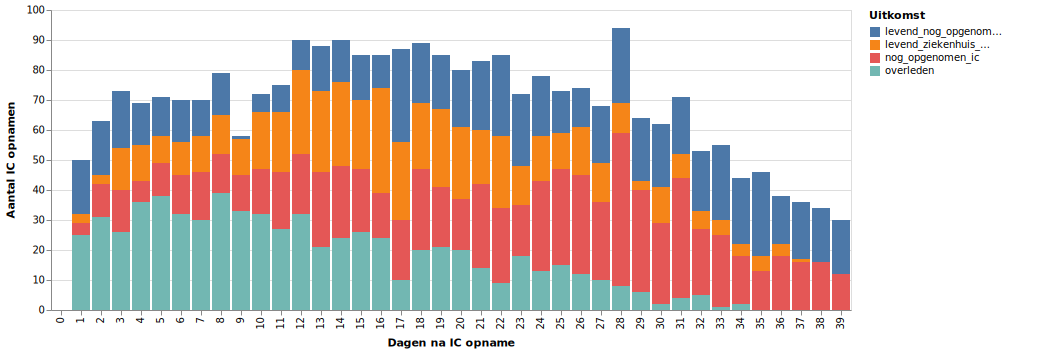

In [7]:
# Take cumulative sum
# move to long format so we can map a column to color channel later
chart_data_bar = treatment_duration_df.reset_index().melt(id_vars='days')

alt.Chart(chart_data_bar).mark_bar().encode(
    x=alt.X('days:O', axis=alt.Axis(title='Dagen na IC opname')),
    y=alt.Y('value:Q', axis=alt.Axis(title='Aantal IC opnamen')),
    color=alt.Color('variable:N', legend=alt.Legend(title='Uitkomst'))
)

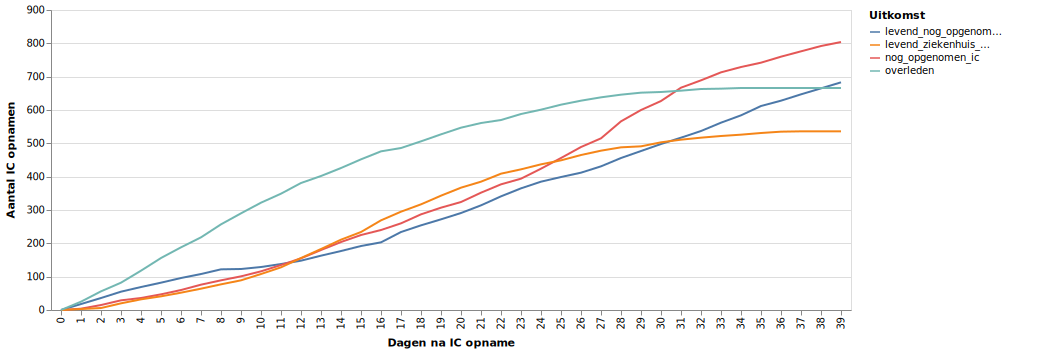

In [8]:
# Take cumulative sum
# move to long format so we can map a column to color channel later
chart_data = treatment_duration_df.cumsum().reset_index().melt(id_vars='days')

alt.Chart(chart_data).mark_line().encode(
    x=alt.X('days:O', axis=alt.Axis(title='Dagen na IC opname')),
    y=alt.Y('value:Q', axis=alt.Axis(title='Aantal IC opnamen')),
    color=alt.Color('variable:N', legend=alt.Legend(title='Uitkomst'))
)

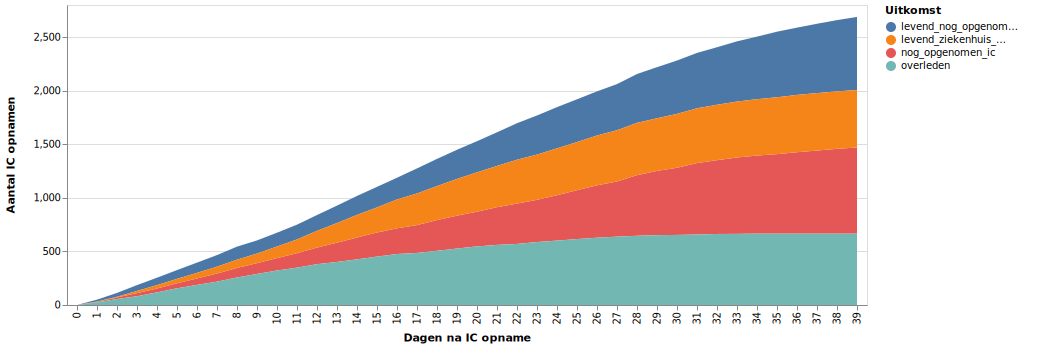

In [9]:
alt.Chart(chart_data).mark_area().encode(
    x=alt.X('days:O', axis=alt.Axis(title='Dagen na IC opname')),
    y=alt.Y('value:Q', axis=alt.Axis(title='Aantal IC opnamen')),
    color=alt.Color('variable:N', legend=alt.Legend(title='Uitkomst'))
)

Via "Patiëntkarakteristieken en uitkomsten" I found the Kaplan-Meier survival curve

https://www.stichting-nice.nl/COVID_rapport_20200420.pdf pg. 8

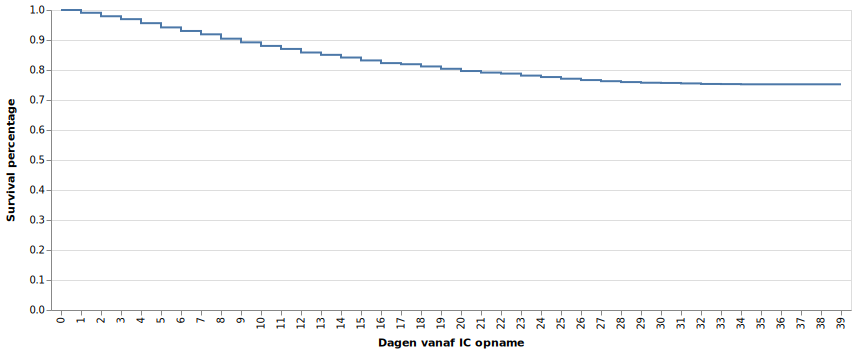

In [29]:
# Survival ratio is the cumulative number of patients deceased up to that amount of days after
# IC start divided by total number of patients.
#
survival_df = treatment_duration_df.copy()
survival_df['survival_ratio'] = 1-survival_df.overleden.cumsum()/survival_df.sum().sum()
   
alt.Chart(survival_df.reset_index()).mark_line(interpolate='step-after').encode(
    x=alt.X('days:O', axis=alt.Axis(title='Dagen vanaf IC opname')),
    y=alt.Y('survival_ratio:Q', axis=alt.Axis(title='Survival percentage'))
)

An attempt for something like the demographic pyramid

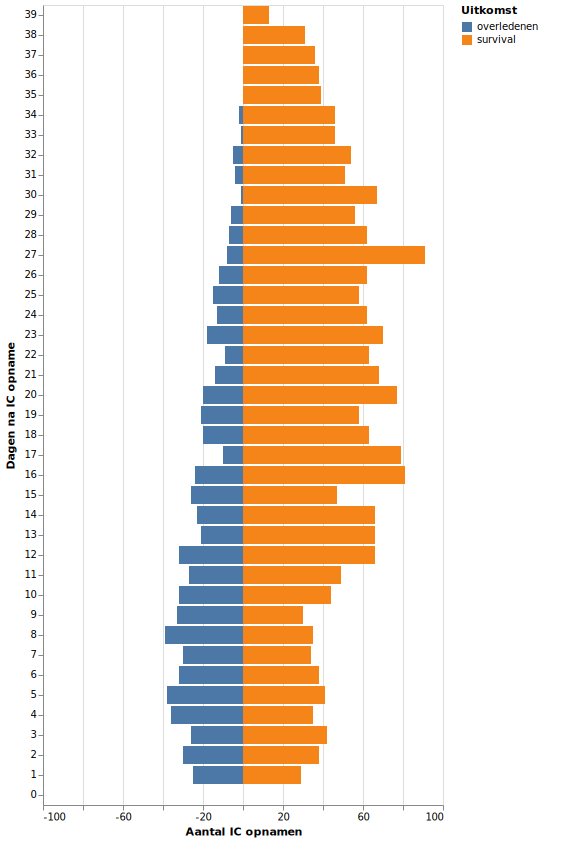

In [8]:
# Pyramid of positive and negative outcome
df = treatment_duration_df.copy()
df['survival'] = df.sum(axis=1) - df.overleden
df['overledenen'] = -df.overleden

chart_data_bar = df[['survival', 'overledenen']].reset_index().melt(id_vars='days')

alt.Chart(chart_data_bar).mark_bar().encode(
    y=alt.Y('days:O', sort='descending', axis=alt.Axis(title='Dagen na IC opname')),
    x=alt.X('value:Q', axis=alt.Axis(title='Aantal IC opnamen'), scale=alt.Scale(domain=(-100, 100))),
    color=alt.Color('variable:N', legend=alt.Legend(title='Uitkomst'))
)
# treatment_duration_df['survival']
#positive.join(negative, how='outer')
# Take cumulative sum
# move to long format so we can map a column to color channel later
#chart_data_bar = treatment_duration_df.reset_index().melt(id_vars='days')
#
#alt.Chart(chart_data_bar).mark_bar().encode(
#    x=alt.X('days:O', axis=alt.Axis(title='Dagen na opname')),
#    y=alt.Y('value:Q', axis=alt.Axis(title='Aantal IC opnamen')),
#    color=alt.Color('variable:N', legend=alt.Legend(title='Uitkomst'))
#)